# Data Story
Phai Phongthiengtham

***

This section provides some basic data exploration:

### Import necessary modules and dataset

In [1]:
import math
import re
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8,4)})
%matplotlib inline
from six.moves import range
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

from identify_outlier import *

dataset_file_name = 'data_10K_no_description.txt'
df = pd.read_csv(dataset_file_name,sep='\t',header=0)

all_edu = ['high_school','associate','bachelor','master','phd']
list_var = ['conml','state','ceq','roe','naics','original_jobtitle','onet'] + all_edu 
df['n'] = 1

### Profitability

This project uses "Return on Equity - ROE": the amount of net income returned as a percantage of shareholders equity (excluding preferred stock).

$$ \text{Return on Equity} = \frac{\text{Net Income}}{\text{Shareholder's Equity}}$$

Average ROE = 0.06442578079295365
Median ROE = 0.09179339794980393


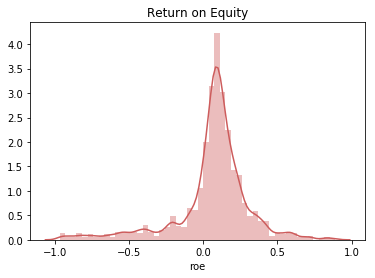

In [2]:
roe_by_firm = df[['conml','roe']].drop_duplicates()
roe_by_firm = roe_by_firm.sort_values('roe')

print('Average ROE = ' + str(roe_by_firm.roe.mean()))
print('Median ROE = ' + str(roe_by_firm.roe.median()))

sns.distplot(roe_by_firm.roe, norm_hist = True, color=sns.desaturate("indianred",1))
plt.title("Return on Equity")

* From the data, we see average ROE of 6.4%. There is, however, a huge spread. Median ROE is 9.18% and we have upto -96.5% and 89% ROE.

In [3]:
roe_by_firm[:5]

,conml,roe
4825,AxoGen Inc,-0.965820
5427,Global Brokerage Inc,-0.964541
358,Brinker International Inc.,-0.942027
7375,Sirius XM Holdings Inc,-0.941817
911,GoPro Inc,-0.937482


* Companies with the lowest ROE.

In [4]:
roe_by_firm[-5:]

,conml,roe
2933,Avis Budget Group Inc,0.737557
935,Glaxosmithkline PLC,0.811387
413,Novo Nordisk A/S,0.837770
139,Intuit Inc.,0.843239
3201,Blue Buffalo Pet Products Inc,0.890001


* Companies with the highest ROE.

In [5]:
# create a feature "roe_high" = 1 if roe is higher than the median roe in the sample:
df['high_roe'] = (df.roe > roe_by_firm.roe.median()).values
df[['high_roe','n']].groupby(['high_roe']).count()

,n
high_roe,
False,3603
True,6397


* The variable *"high_roe"* is *True* if the company has higher ROE than the median ROE in the sample. 
* Successful companies post more ads.

### Occupation

Next, we look at the postings by occupation. Overall, there are three main occupation groups:

In [6]:
def assign_onet3digit_description(onet, full_description = True):
    if re.findall(r'\d{2}-\d{1}',onet):
        onet3digit = re.findall(r'\d{2}-\d{1}',onet)[0]
        if full_description == True:
            if onet3digit == '11-1':
                output = '111 : Top Executives'
            elif onet3digit == '11-2': 
                output = '112 : Advertising, Public Relations, and Sales Managers'
            elif onet3digit == '11-3': 
                output = '113 : Operations Managers'
            elif onet3digit == '11-9':
                output = '119 : Other Management Occupations'
        else:
            output = re.sub('[^0-9]','',onet3digit)
            
    return output

df['onet3digit'] = df['onet'].apply(lambda x: assign_onet3digit_description(x, full_description = True))
df['onet3digit_numer'] = df['onet'].apply(lambda x: assign_onet3digit_description(x, full_description = False))
df['onet3digit'].unique()

array(['119 : Other Management Occupations', '113 : Operations Managers',
       '112 : Advertising, Public Relations, and Sales Managers',
       '111 : Top Executives'], dtype=object)

In [7]:
df_occ = df[['onet3digit','n']]
df_occ = df_occ.groupby(['onet3digit']).count()
df_occ

,n
onet3digit,
111 : Top Executives,1223
"112 : Advertising, Public Relations, and Sales Managers",2672
113 : Operations Managers,2590
119 : Other Management Occupations,3515


* Most ads are *Other Management Occupations*. See ONET website [here](https://www.onetonline.org/find/quick?s=119) for more detail. 

In [8]:
df_occ = df[['onet3digit','n','high_roe']]
df_occ = df_occ.groupby(['onet3digit','high_roe']).count()
df_occ.unstack()

n      
high_roe                                           False True 
onet3digit                                                    
111 : Top Executives                                 408   815
112 : Advertising, Public Relations, and Sales ...   928  1744
113 : Operations Managers                            925  1665
119 : Other Management Occupations                  1342  2173

* More successful companies (*"high_roe" == True*) post more top executives proportionally. 

### Education Requirement

Next, we look at education requirement:

In [9]:
df_education = df[['onet3digit','high_roe'] + all_edu]
df_education[all_edu].mean()

high_school    0.0903
associate      0.0595
bachelor       0.5795
master         0.1751
phd            0.0205
dtype: float64

* Most ads (58%) specifically require Bachelor's degree, followed by Master's degree (17.51%). 

In [10]:
df_education = df_education.groupby(['onet3digit','high_roe']).mean()
df_education = df_education.reset_index()
df_education_low = df_education[df_education['high_roe']==False]
df_education_high = df_education[df_education['high_roe']==True]
df_education_roe = df_education_high.append(df_education_low, ignore_index=True)

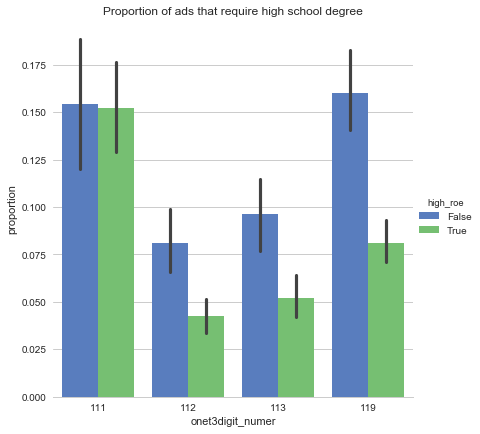

In [11]:
sns.set(style="whitegrid")

# Draw a nested barplot
# example: https://seaborn.pydata.org/examples/factorplot_bars.html

g = sns.factorplot(x='onet3digit_numer', y="high_school", hue="high_roe", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("proportion")
plt.title('Proportion of ads that require high school degree')

* Successful companies are less likely to specify require high school degree as requirement.

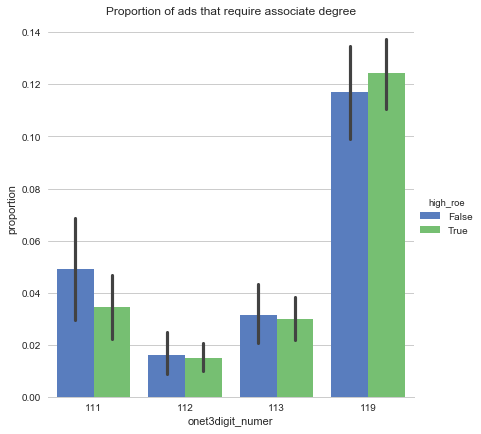

In [12]:
# Draw a nested barplot
g = sns.factorplot(x='onet3digit_numer', y="associate", hue="high_roe", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("proportion")
plt.title('Proportion of ads that require associate degree')

* Successful companies are less likely to specify require associate degree as requirement.

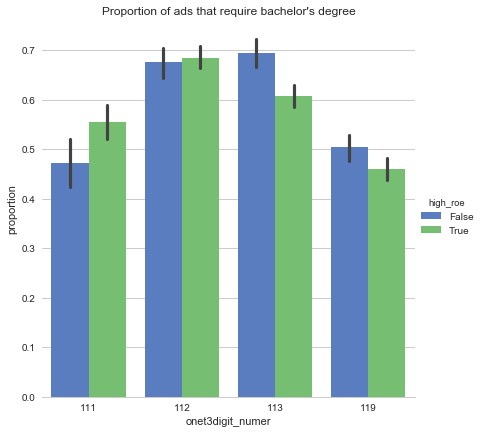

In [13]:
# Draw a nested barplot
g = sns.factorplot(x='onet3digit_numer', y="bachelor", hue="high_roe", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("proportion")
plt.title("Proportion of ads that require bachelor's degree")

* Successful companies are more likely to specify require bachelor's degree as requirement for 111 : Top Executives and 112 : Advertising, Public Relations.

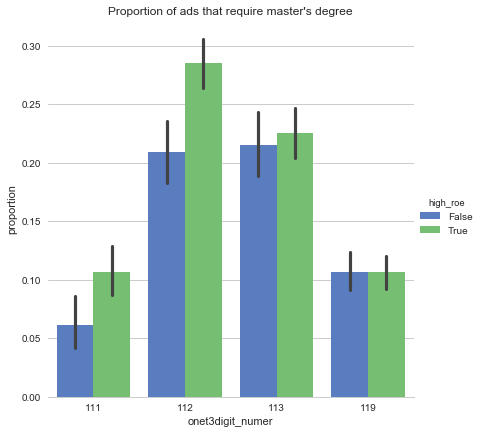

In [14]:
# Draw a nested barplot
g = sns.factorplot(x='onet3digit_numer', y="master", hue="high_roe", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("proportion")
plt.title("Proportion of ads that require master's degree")

* Successful companies are more likely to specify require master's degree.

### Summary

1. From the data, we see average ROE of 6.4%. There is, however, a huge spread. Median ROE is 9.18% and we have upto -96.5% and 89% ROE.
2. Successful companies post more ads.
3. Successful companies post more top executives proportionally.
4. Most ads (58%) specifically require Bachelor's degree, followed by Master's degree (17.51%). 
5. Successful companies often specify higher education requirement. 

These results are not surprising. Expanding companies are most likely the ones with higher profitability. These companies, therefore, have more jobs to fill, demand more top executives, and are able to extract better employees by requesting for higher education requirement.  